#Data Preprocessing & Preperation

In this notebook, we are aiming to determine what factors, if any, contribute to the liklihood of post operative death in cardiac patients.  The data was derived from the [inspire dataset](https://physionet.org/content/inspire/1.2/) and aims to be a useful tool perioperative medicine.

Below, follow the comments above each line of code to see what the objectives are in identifying our target variables and cleaning the data

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# Set variables
OUTCOME_VAR = 'inhosp_death_30day'
INPUT_VARS = ['age', 'bmi', 'andur', 'asa', 'emop',
              'preop_hb', 'preop_platelet', 'preop_wbc', 'preop_aptt', 'preop_ptinr', 'preop_glucose',
              'preop_bun', 'preop_ast', 'preop_alt', 'preop_creatinine', 'preop_sodium', 'preop_potassium',
              'Index', 'Elixhauser Indicator']

# Load operations
df = pd.read_csv('operations.csv')

# Find the first operation for each patient
df.sort_values('orin_time', inplace=True)
df = df.loc[df[['op_id','subject_id']].groupby('subject_id')['op_id'].idxmin()]

# Whether the time of in-hospital death ('inhosp_death_time') is less than the time when the patient was
# out of the operating room ('orout_time') plus 30 days (converted to minutes).
df[OUTCOME_VAR] = (df['inhosp_death_time'] < df['orout_time'] + 30 * 24 * 60)

# Filters to include only those rows where the value in the column 'asa' is less than 6. higher asa indicates more serious disease
df = df[(df['asa'] < 6)]

# Duration of anesthesia for each patient
df.loc[:, 'andur'] = df['anend_time'] - df['anstart_time']

# BMI only for rows where valid_mask is True (i.e., where height is greater than 10 cm).
valid_mask = df['height'] > 10
df['bmi'] = np.nan
df.loc[valid_mask, 'bmi'] = df.loc[valid_mask, 'weight'] / (df.loc[valid_mask, 'height'] / 100) ** 2

# Load labs
df_lab = pd.read_csv('labs.csv')

# Merge labs & operations
for item_name in ('hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'ast', 'alt', 'creatinine', 'sodium', 'potassium'):
    df = pd.merge_asof(df.sort_values('orin_time'),
                    df_lab.loc[df_lab['item_name'] == item_name].sort_values('chart_time'),
                    left_on='orin_time', right_on='chart_time', by='subject_id',
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'preop_{item_name}'}, inplace=True)

# Load diagnosis data
df_diagnosis = pd.read_csv('diagnosis.csv')

# Merge diagnosis data with operations & medications
df = pd.merge(df, df_diagnosis[['subject_id', 'icd10_cm']], on='subject_id', how='left')

# Moving icd10_pcs to back of datafrmae
col = df.pop('icd10_pcs')
df['icd10_pcs'] = col

# cardiac patients pcs list
cardiac_patients_list = [
    "02RG0", "02100", "03BY0", "03VG3", "00160", "06BY0", "02QM0", "03120",
    "05DY0", "02RF0", "02B60", "031H0", "04100", "05HY0", "021K0", "03LG0",
    "03Q20", "03CY0", "03LG3", "02RJ0", "031J0", "001U0", "02C60", "03CH0",
    "02QF0", "05BY0", "04BK0", "04CY0", "03C50", "02B63", "037H0", "02110",
    "04RY0", "03VG0", "03R20", "03LY3", "03L20", "03B20", "047Y3", "03VH0",
    "03130", "05QY0", "0HRT0", "03720", "03L24", "03BJ0", "02YA0", "03CJ0",
    "03RY0", "0HRU0", "04CK0", "021W0", "02QG0", "04BY0", "03LK3", "02QJ0",
    "03LY0", "05VY0", "03920", "03C20", "02JA0", "06DM0", "06LY0", "04C50",
    "02BF0", "06BN0", "02Q00", "02B64", "02RA0", "03L23", "041L0", "04BL0",
    "06BM0", "06C80", "02QA0", "04CL0", "047Y0", "05LY0", "03VY0", "03140",
    "02Q60", "03QY0", "021P0", "02114", "06DN0", "03LK0", "02UF0", "03BY3"
]

# just cardiac patients
df = df[df['icd10_pcs'].isin(cardiac_patients_list)]

# drop duplicate patients
df = df.drop_duplicates(subset='subject_id')

# Sort the dataframe by subject_id in increasing order
df.sort_values('subject_id', inplace=True)

# Fill all NA values with 0
df.fillna(0, inplace=True)

# Read in filtered icd codes
icd10_cm_scores_df = pd.read_csv("all_patients_with_elixhauser_scores.csv")
icd10_pcs_scores_df = pd.read_csv("processed_icd10_pcs_codes_with_categories.csv")

# Merge Elixhauser scores with the main dataframe
df = pd.merge(df, icd10_cm_scores_df[['subject_id', 'Elixhauser Indicator']], on='subject_id', how='left')

# Set the indexes of the ICD10 scores dataframes for faster lookups
icd10_pcs_scores_df.set_index('ICD10 Code', inplace=True)

# Create a dictionary for faster lookups
icd10_pcs_dict = icd10_pcs_scores_df['Index'].to_dict()

# Add the comorbidities scores to df
df['Index'] = df['icd10_pcs'].map(icd10_pcs_dict)

# check the dataframe
len(df)
df.head()

,op_id,subject_id,hadm_id,case_id,opdate,age,sex,weight,height,race,asa,emop,department,antype,orin_time,orout_time,opstart_time,opend_time,admission_time,discharge_time,anstart_time,anend_time,cpbon_time,cpboff_time,icuin_time,icuout_time,inhosp_death_time,inhosp_death_30day,andur,bmi,preop_hb,preop_platelet,preop_aptt,preop_wbc,preop_ptinr,preop_glucose,preop_bun,preop_ast,preop_alt,preop_creatinine,preop_sodium,preop_potassium,icd10_cm,icd10_pcs,Elixhauser Indicator,Index
0,464232551,100010304,212882335,0.0,0,50,F,68.0,160.0,Asian,2.0,1,NS,General,320,490,420.0,480.0,0,21595,400.0,495.0,0.0,0.0,515.0,6660.0,0.0,False,95.0,26.562500,13.7,222.0,30.1,8.90,1.07,138.0,7.0,26.0,27.0,0.47,139.0,3.4,I60,03VG3,0,13
1,456670941,100017370,220754512,0.0,2880,75,M,53.0,163.0,Asian,3.0,0,CTS,General,3350,3730,3420.0,3720.0,0,15835,3355.0,3725.0,3480.0,3650.0,3730.0,5050.0,0.0,False,370.0,19.948060,11.9,211.0,31.2,6.30,0.90,0.0,24.0,20.0,7.0,0.80,139.0,3.8,I35,02RF0,0,13
2,418301274,100030721,276079965,0.0,1440,70,M,64.0,163.0,Asian,1.0,0,NS,General,2085,2235,2100.0,2225.0,0,4315,2085.0,2240.0,0.0,0.0,0.0,0.0,0.0,False,155.0,24.088223,13.7,258.0,32.3,10.22,0.97,96.0,16.0,31.0,30.0,0.71,140.0,4.2,I89,03VG3,0,13
3,417236553,100036262,292040258,0.0,2880,35,F,51.0,160.0,Asian,3.0,0,NS,General,3340,3730,3405.0,3685.0,0,15835,3350.0,3725.0,0.0,0.0,3750.0,6580.0,0.0,False,375.0,19.921875,13.2,314.0,38.2,7.05,1.12,84.0,9.0,19.0,17.0,0.68,139.0,4.0,0,031J0,0,1
4,451064657,100038610,284969054,0.0,8640,50,M,75.0,179.0,Asian,2.0,0,CTS,General,9070,9625,9180.0,9615.0,0,17275,9120.0,9620.0,9265.0,9515.0,9620.0,11225.0,0.0,False,500.0,23.407509,13.7,233.0,33.0,5.58,0.98,115.0,12.0,31.0,35.0,0.74,141.0,3.8,I20,02110,0,1


In [11]:
# optionally save the dataset for analysis

df.to_csv('cardiac-subjects-jun20-updated.csv', index=False)

len(df)

4856

#Modeling & Graphs

Utilizing Logisitic Regression and various sampling techniques to address imbalances in the dataset, we are using machine learning to determine the liklihood of post-operative death in cardiac patients and plotting the model results

Original train set class distribution: [3362   37]
Original test set class distribution: [1441   16]
Resampled train set class distribution: [3362 3362]
LR auroc: 0.831, auprc: 0.149
 
 


<ipython-input-18-c16bea5d6cd9>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_coefficients, y=sorted_features, palette='coolwarm')


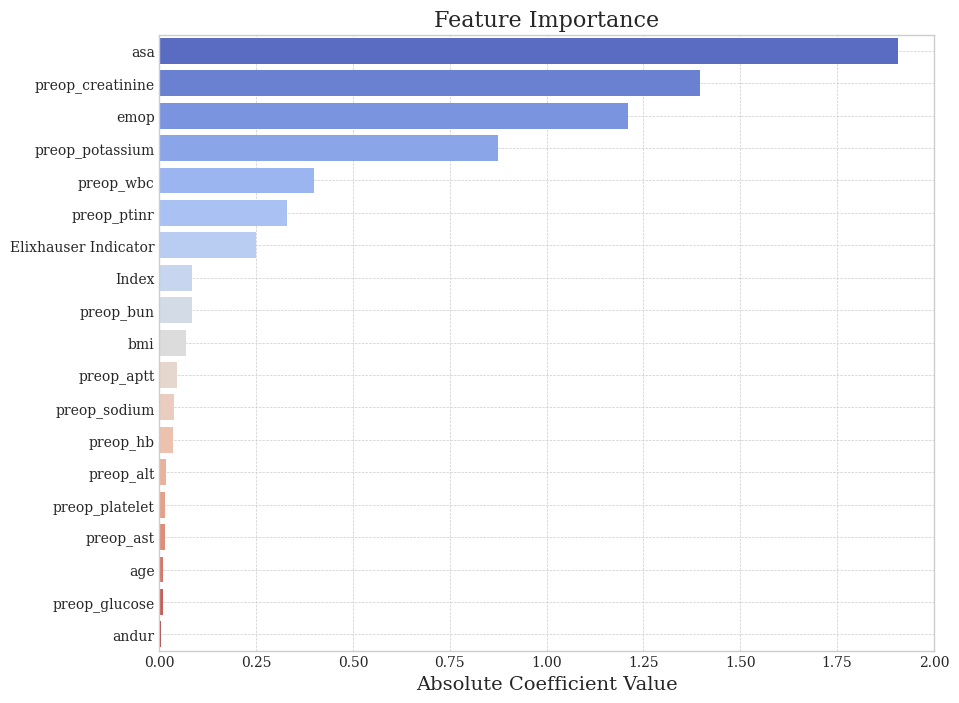

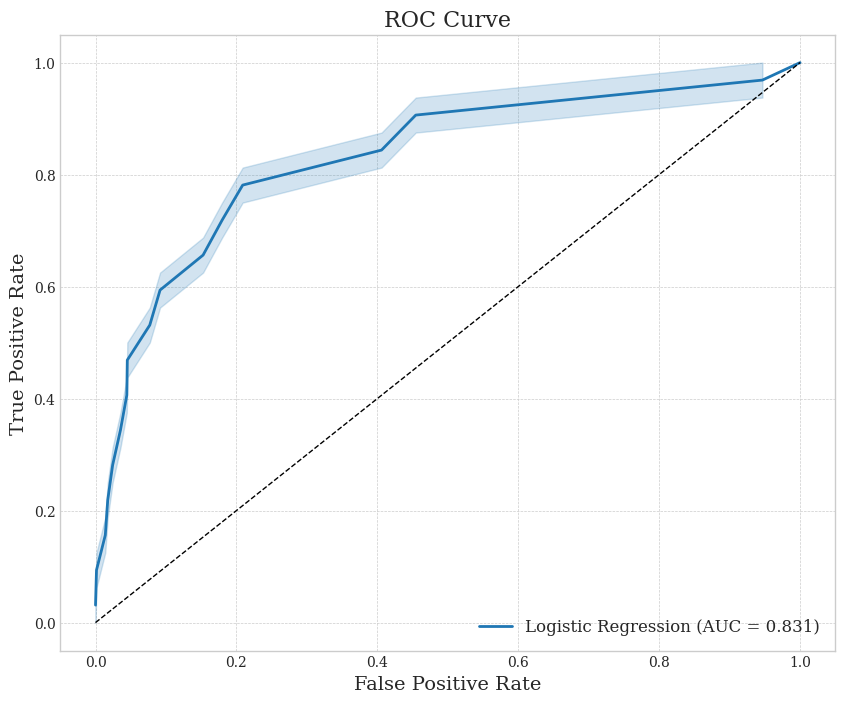

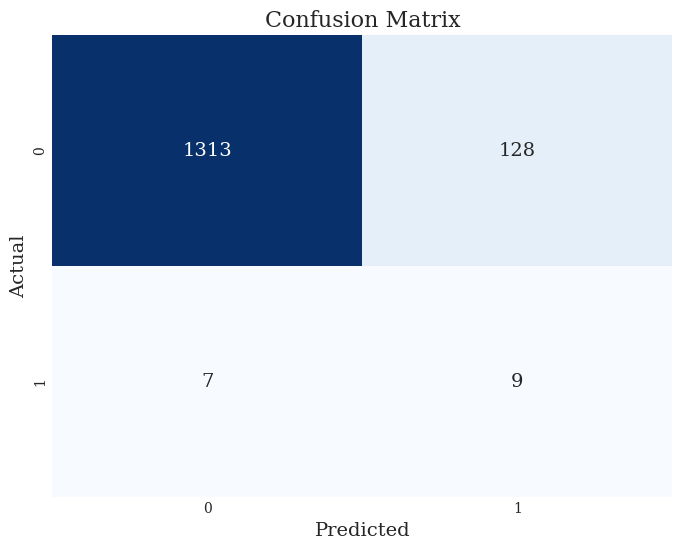

Accuracy: 0.907
Precision: 0.066
Recall: 0.562
F1 Score: 0.118


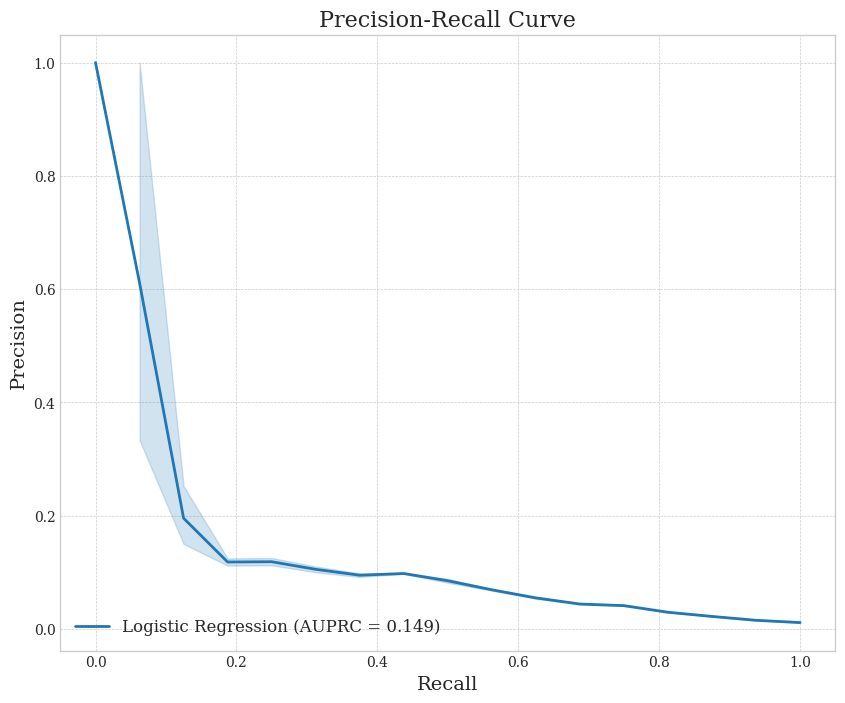

      Metric  Logistic Regression
0   Accuracy             0.907344
1  Precision             0.065693
2     Recall             0.562500
3   F1 Score             0.117647
4      AUROC             0.831324
5      AUPRC             0.148632
              op_id    subject_id       hadm_id       case_id        opdate  \
count  4.856000e+03  4.856000e+03  4.856000e+03   4856.000000  4.856000e+03   
mean   4.460692e+08  1.502260e+08  2.501051e+08     49.279036  9.560461e+04   
std    2.912596e+07  2.867030e+07  2.861470e+07   7705.441436  4.560450e+05   
min    4.000170e+08  1.000103e+08  2.000048e+08 -32717.000000  0.000000e+00   
25%    4.202172e+08  1.255292e+08  2.253534e+08      0.000000  1.440000e+03   
50%    4.447431e+08  1.504818e+08  2.505266e+08      0.000000  2.880000e+03   
75%    4.715495e+08  1.751646e+08  2.748569e+08      0.000000  7.200000e+03   
max    4.999286e+08  1.999877e+08  2.999760e+08  32754.000000  4.940640e+06   

               age       weight       height      

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

# Shuffle and split the dataset
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
ntrain = int(len(df) * 0.7)

# Stratified split
x_train, x_test, y_train, y_test = train_test_split(
    df[INPUT_VARS], df[OUTCOME_VAR], test_size=0.3, stratify=df[OUTCOME_VAR], random_state=1
)

# Print the original class distribution
print(f'Original train set class distribution: {np.bincount(y_train)}')
print(f'Original test set class distribution: {np.bincount(y_test)}')

# Apply SMOTE to the training data
smote = SMOTE(random_state=1)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Apply RandomUnderSampler to the SMOTE resampled data
rus = RandomUnderSampler(random_state=1)
x_train_balanced, y_train_balanced = rus.fit_resample(x_train_smote, y_train_smote)

# Print the new class distribution after balancing
print(f'Resampled train set class distribution: {np.bincount(y_train_balanced)}')

# Logistic regression using SimpleImputer
imp = SimpleImputer().fit(x_train_balanced)
x_train_imputed = imp.transform(x_train_balanced)
x_test_imputed = imp.transform(x_test)

# Logistic regression using LogisticRegression
model = LogisticRegression(max_iter=5000).fit(x_train_imputed, y_train_balanced)
y_pred_lr = model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_lr = roc_auc_score(y_test, y_pred_lr)
prc_lr, rec_lr, thresholds = precision_recall_curve(y_test, y_pred_lr)
auprc_lr = auc(rec_lr, prc_lr)
print('LR auroc: {:.3f}, auprc: {:.3f}'.format(auroc_lr, auprc_lr), flush=True)
print(" \n ")

# Compute feature importance
feature_names = x_train.columns
coefficients = model.coef_[0]

# Create a list of (feature_name, absolute_coefficient) tuples and sort them by the coefficient value
features_coefficients = sorted(zip(feature_names, abs(coefficients)), key=lambda x: x[1], reverse=True)

# Unzip the feature names and their corresponding coefficients into separate lists
sorted_features, sorted_coefficients = zip(*features_coefficients)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_coefficients, y=sorted_features, palette='coolwarm')
plt.xlabel('Absolute Coefficient Value', fontsize=14)
plt.title('Feature Importance', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# ROC Curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

plt.figure(figsize=(10, 8))
sns.lineplot(x=fpr_lr, y=tpr_lr, label=f'Logistic Regression (AUC = {auroc_lr:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Confusion Matrix
y_pred_label_lr = (y_pred_lr >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_label_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Print model performance metrics
accuracy = accuracy_score(y_test, y_pred_label_lr)
precision = precision_score(y_test, y_pred_label_lr)
recall = recall_score(y_test, y_pred_label_lr)
f1 = f1_score(y_test, y_pred_label_lr)
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
sns.lineplot(x=rec_lr, y=prc_lr, label=f'Logistic Regression (AUPRC = {auprc_lr:.3f})', linewidth=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='lower left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Tables

# Model Performance Metrics
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'AUPRC'],
    'Logistic Regression': [accuracy, precision, recall, f1, auroc_lr, auprc_lr]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Descriptive Statistics of the Dataset
desc_stats = df.describe()
print(desc_stats)

# Logistic Regression Coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)
print(coef_df)

# Confusion Matrix (numerical representation)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(cm_df)


#Saving The Trained Model for Further Use!

full repository located [here](https://github.com/hofmannj0n/biomedical-research)

In [20]:
import pickle

with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('imputer.pkl', 'wb') as imputer_file:
    pickle.dump(imp, imputer_file)